# Models

In [1]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import reduce

## WAM模型
### 属性
- chunksize
    - 样本窗口宽度
- arr_length
    - 考虑碱基关联的阶数
- positive_weights
    - 阳性样本权重
- negative_weights
    - 阴性样本权重
### 方法
- fit
    - 拆分阳性和阴性样本
    - 统计碱基信息
    - 更新权重及归一化
- predict
    - predict_probas计算概率
    - predict_scores打分
    - predict_classes分类

In [109]:
class WAM:
    
    def __init__(self, chunk_size=21, arr_length=2, psuedo_count=0.5):
        self.chunk_size = chunk_size
        self.arr_length = arr_length
        
        # init wam weights
        weights_init = np.zeros( (chunk_size, 4**arr_length) , dtype=np.float)
        self.nucleo_arrays = self._nucleo_arrays(arr_length)
        self.positive_weights = pd.DataFrame(weights_init, columns=self.nucleo_arrays)
        self.negative_weights = pd.DataFrame(weights_init, columns=self.nucleo_arrays)
        
        # use psuedo count
        counts_init = np.full(weights_init.shape, psuedo_count)
        counts_init[0:2] = np.NaN
        self._init_count_matrix = pd.DataFrame(counts_init, columns=self.nucleo_arrays)
        
    def fit(self, data, labels):
        pos_indeces = labels == 1
        neg_indeces = labels == 0
        pos_data = data[pos_indeces].copy().reset_index(drop=True)
        neg_data = data[neg_indeces].copy().reset_index(drop=True)
        
        if pos_data.shape[0] > 0: 
            self.positive_weights += self._cal_freq_matrix(pos_data)
        if neg_data.shape[0] > 0:
            self.negative_weights += self._cal_freq_matrix(neg_data)
        
        self.positive_weights = self.positive_weights.apply(lambda x: x / x.sum(), axis=0)
        self.negative_weights = self.negative_weights.apply(lambda x: x / x.sum(), axis=0)
        
    def _cal_freq_matrix(self, data):
        # init
        count_matrix = self._init_count_matrix.copy()
        
        # count
        cn = self._count_nucleo
        count_matrix = count_matrix.apply(lambda x: x + (cn(data, x.name)), axis=0) # by column
        #print(count_matrix)
        # normalize
        count_matrix = count_matrix.apply(lambda x: x / x.sum(), axis=0) # by column
        
        return count_matrix
        
    def _count_nucleo(self, data, nucleo_pattern):
        
        # get all ends of pattern appeared in the sequence data
        #print(nucleo_pattern)
        nucleo_pat = re.compile(pattern=nucleo_pattern)
        find_ends = lambda x: [i.span()[1] for i in nucleo_pat.finditer(x)]
        ends = data.apply(find_ends)

        ends = reduce(lambda x, y: x + y, ends)
        #print(ends)
        # count ends as a feature vector
        l = len(data[0])
        
        #counts = [ends.count(i) for i in range(self.arr_length, l)]
        counts = [ends.count(i) for i in range(l)]
        #print(counts)
        return pd.Series(counts)
        
    def _nucleo_arrays(self, arr_length):
        bases = ['A', 'C', 'G', 'T']
        arrays = reduce(lambda x,y: [i+j for i in x for j in y], [bases] * arr_length)
        return arrays
        
    def predict_classes(self, data, T):
        scores = self.predict_scores(data)
        classes = np.zeros(scores.shape, dtype=np.int)
        isGreater = scores >= T
        classes[isGreater] = 1
        return classes
        
    def predict_probas(self, data):
        scores = data.apply(self._score).tolist()
        probas = pd.DataFrame(scores, columns=['Positive probability','Negative probability'])
        return probas.apply(lambda x: x / x.sum(), axis=1)
    
    def predict_scores(self, data):
        probas = self.predict_probas(data)
        score = np.log( probas['Positive probability'] / probas['Negative probability'] )
        return score
    
    def _score(self, sample):
        # 记得更新
        pos_weights = self.positive_weights
        neg_weights = self.negative_weights
        
        arrlen = self.arr_length
        pos_probas = [pos_weights.loc[i, sample[i-arrlen:i]] for i in range(arrlen, len(sample))]
        neg_probas = [neg_weights.loc[i, sample[i-arrlen:i]] for i in range(arrlen, len(sample))]
        
        pos_Proba = reduce(lambda x, y: x * y, pos_probas)
        neg_Proba = reduce(lambda x, y: x * y, neg_probas)
        
        # return positive and negative probas
        return [pos_Proba, neg_Proba]

,Positive probability,Negative probability
0,0.956839,0.043161
1,0.956839,0.043161


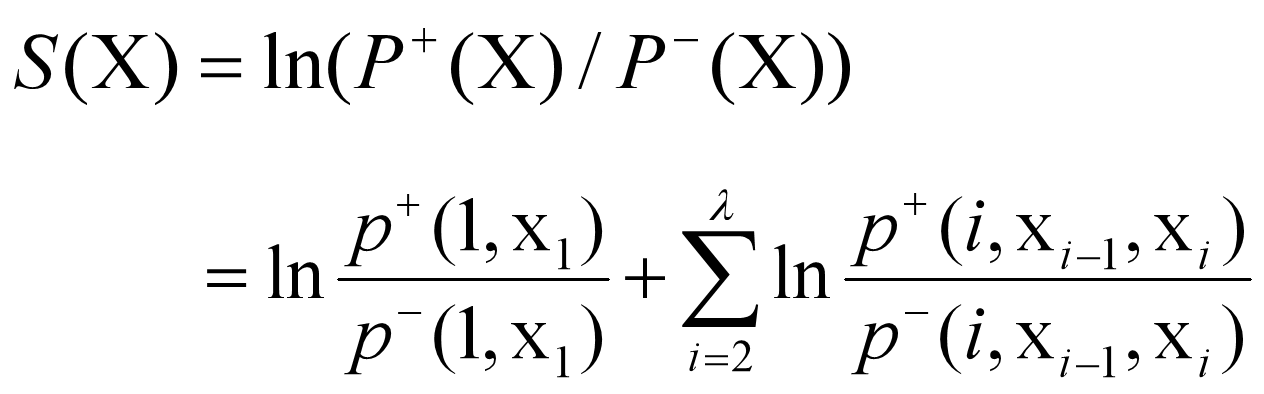

## BN模型


In [ ]:
# BN learning: https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/9.%20Learning%20
# Bayesian%20Networks%20from%20Data.ipynb

from pgmpy.estimators import MmhcEstimator, MaximumLikelihoodEstimator, K2Score, BayesianEstimator, BDeuScore, BicScore
from pgmpy.models import BayesianModel


class BN:
    def __init__(self, struc_estr=MmhcEstimator, param_estr=BayesianEstimator):
        self.struc_estr = struc_estr
        self.param_estr = param_estr
        self.types = ['positive', 'negative']
        self.networks = {'positive': BayesianModel(), 'negative': BayesianModel()}
        
    def fit(self, data, label, sign_level=0.01):
        features = pd.DataFrame(data, columns=['F{}'.format(i) for i in range(data.shape[1])])
        label = pd.DataFrame(label, columns=['label'])
        data = pd.concat( (features, label), axis=1)
        
        data = {'positive': data[data['label']==1], 'negative': data[data['label']==0]}
        data['negative']['label'] = 1
        # structure learning
        print('Performing structure learning, using estimator: `{}`'.format(self.struc_estr))
        for type_ in ['positive', 'negative']:
            struc_estr = self.struc_estr(data[type_])
            DAG = struc_estr.estimate(significance_level=sign_level, scoring_method=BDeuScore(data[type_]))   
            # parameters, status for each feature ?
            self.networks[type_].add_edges_from(DAG.edges) 
            self.networks[type_].add_nodes_from([ node for node in data[type_].columns 
                                                 if not self.networks[type_].has_node(['node']) ])
        # plot structure
        print('Done !')
        # parameter learning
        print('Performing parameter learning, using estimator: `{}`'.format(self.param_estr))
        for type_ in ['positive', 'negative']:
            self.networks[type_].fit(data[type_], estimator=self.param_estr)
        
    
    def predict_probas(self, data):
        data = self.make_missingL_data(data)
        # check
        probas = pd.DataFrame({ type_: self.network[type_].predict_probability(data)[str(i)] 
                               for i, type_ in enumerate(reversed(self.types)) }) 
        # probas = pd.DataFrame({type_: })
        return probas
        
    def predict_classes(self, data, T):
        scores = self.predict_scores(data)
        classes = pd.Series( np.ones(scores.shape) ) # init
        classes[scores > T] = 1
        return classes
        
    def predict_scores(self, data):
        probas = self.predict_probas(data)
        scores = np.log( probas['positive'] / probas['negative'] )
        return scores
        
    def make_missingL_data(self, data):
        features = pd.DataFrame(data, columns=['F{}'.format(i) for i in range(data.shape[1])])
        label = pd.DataFrame(np.zeros(features.shape[0]), columns=['label'])
        data = pd.concat( (features, label), axis=1)
        data.drop('label', axis=1, inplace=True)
        return data

Performing structure learning, using estimator: `<class 'pgmpy.estimators.MmhcEstimator.MmhcEstimator'>`


/home/chonghui/.local/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:92: UserWarning: Insufficient data for testing F0 _|_ F3 | ['F6', 'F7', 'F2']. At least 40 samples recommended, 29 present.
  warn(
/home/chonghui/.local/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:92: UserWarning: Insufficient data for testing F0 _|_ F5 | ['F6', 'F7', 'F2']. At least 40 samples recommended, 29 present.
  warn(
/home/chonghui/.local/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:92: UserWarning: Insufficient data for testing F0 _|_ F8 | ['F6', 'F7', 'F2']. At least 40 samples recommended, 29 present.
  warn(
/home/chonghui/.local/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:92: UserWarning: Insufficient data for testing F0 _|_ F9 | ['F6', 'F7', 'F2']. At least 40 samples recommended, 29 present.
  warn(
/home/chonghui/.local/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:92: UserWarning: Insufficient data for testing F0 _|_ F4 | ['F6', 'F7', 'F2']. At 

    [1] Koller & Friedman, Probabilistic Graphical Models - Principles and Techniques, 2009
    Section 18.2.2.3 (page 789)
    [2] Neapolitan, Learning Bayesian Networks, Section 10.3 (page 600ff)
        http://www.cs.technion.ac.il/~dang/books/Learning%20Bayesian%20Networks(Neapolitan,%20Richard).pdf
    [3] Chi-square test https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#Test_of_independence
    [4] Tsamardinos et al., The max-min hill-climbing BN structure learning algorithm, 2005, Section 4

Tsamardinos et al., The max-min hill-climbing Bayesian network structure learning algorithm (2005),

Algorithm 3

http (//www.dsl-lab.org/supplements/mmhc_paper/paper_online.pdf)

## SVM模型

In [112]:
from sklearn import svm

class SVM(svm.SVC):
    
    def predict_classes(self, data):
        return self.predict(data)
    
    def predict_probas(self, data):
        return self.predict_proba(data)
        
    def predict_scores(self, data):
        probas = self.predict_probas(data)
        # 正负如何区分？
        #print(probas)
        scores = np.log(probas[:, 1] / probas[:, 0])
        return scores